<a href="https://colab.research.google.com/github/Chandni0369/ML-LAB-D11ADA-57/blob/main/ML_exp5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving gender_submission.csv to gender_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [2]:
import io
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import joblib

In [3]:
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
print('Loaded:', train.shape, test.shape)

Loaded: (891, 12) (418, 11)


In [4]:
def preprocess(df):
    df = df.copy()
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    df['Title'] = df['Title'].replace('Mlle','Miss')
    df['Title'] = df['Title'].replace('Ms','Miss')
    df['Title'] = df['Title'].replace('Mme','Mrs')
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
    df = pd.get_dummies(df, columns=['Embarked','Title'], drop_first=True)
    df = df.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, errors='ignore')
    return df

test_ids = test['PassengerId'].copy()
train_p = preprocess(train)
test_p = preprocess(test)

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-4245351847.py:3: SyntaxWarning: invalid escape sequence '\.'
  df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [5]:
X = train_p.drop('Survived', axis=1)
y = train_p['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f'{name} Validation Accuracy: {acc:.4f}')
    print(classification_report(y_val, preds))
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f'{name} CV Mean: {cv_scores.mean():.4f}, CV Std: {cv_scores.std():.4f}\n')
    results[name] = {'model': model, 'cv_mean': cv_scores.mean()}

LogisticRegression Validation Accuracy: 0.8212
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       110
           1       0.80      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179

LogisticRegression CV Mean: 0.8171, CV Std: 0.0200

DecisionTree Validation Accuracy: 0.8268
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.80      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179

DecisionTree CV Mean: 0.7710, CV Std: 0.0183

RandomForest Validation Accuracy: 0.8268
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       110
          

Best Model: LogisticRegression


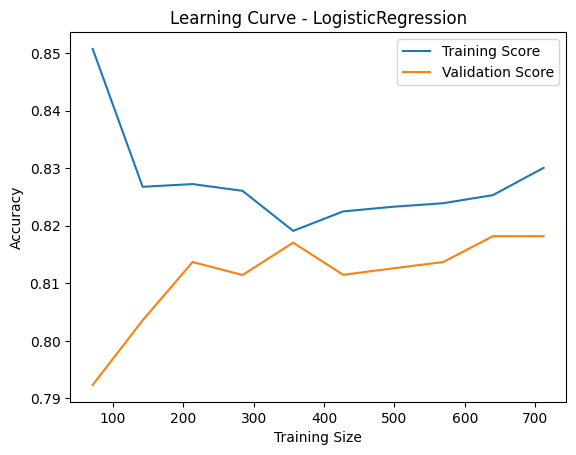

In [6]:
best_name = max(results, key=lambda k: results[k]['cv_mean'])
best_model = results[best_name]['model']
print('Best Model:', best_name)

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X, y, cv=5, train_sizes=np.linspace(0.1,1.0,10), scoring='accuracy', shuffle=True, random_state=42
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, val_mean, label='Validation Score')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title(f'Learning Curve - {best_name}')
plt.legend()
plt.show()

In [7]:
import joblib

joblib.dump(best_model, 'best_model.joblib')
preds = best_model.predict(test_p)
submission = pd.DataFrame({'PassengerId': test_ids, 'Survived': preds})
submission.to_csv('submission.csv', index=False)

from google.colab import files
files.download('submission.csv')
files.download('best_model.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>